In [1]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
start_date = datetime(2024, 4, 16)  # Data de início (exemplo: 1º de janeiro de 2023)
end_date = datetime(2024, 11, 6) 


In [2]:
mt5.initialize()

login = 3014967797
password = 'kSS2FF5#'
server = 'Rico-DEMO'

mt5.login(login, password, server)

symbol = "BBAS3F"

timeframe = mt5.TIMEFRAME_D1
df = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
df['time'] = pd.to_datetime(df['time'], unit='s') 

In [3]:
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-04-17,28.03,28.19,27.80,27.98,21742,1,238215
1,2024-04-18,28.10,28.23,27.72,27.97,17866,1,207215
2,2024-04-19,27.97,28.05,27.68,27.74,18386,1,199862
3,2024-04-22,27.80,28.07,27.26,27.39,28569,1,319771
4,2024-04-23,27.40,27.75,27.02,27.70,18777,1,190321
...,...,...,...,...,...,...,...,...
109,2024-09-19,28.38,28.48,27.95,27.95,21138,1,228408
110,2024-09-20,27.90,27.91,27.47,27.52,30886,1,357325
111,2024-09-23,27.52,27.68,27.29,27.40,30673,1,284038
112,2024-09-24,27.72,27.91,27.38,27.51,21380,1,229260


In [4]:
df['MA_9'] = df['close'].rolling(window=9).mean()     # Curto prazo
df['MA_50'] = df['close'].rolling(window=50).mean()   # Médio prazo
#df['MA_200'] = df['close'].rolling(window=200).mean() # Longo prazo

In [5]:
# Calculando o MACD
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [6]:
# Função para calcular o RSI
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Aplicando a função
df['RSI'] = calculate_rsi(df, window=14)

In [7]:
# Média Móvel de Volume para identificar mudanças
df['Volume_MA_20'] = df['real_volume'].rolling(window=20).mean()

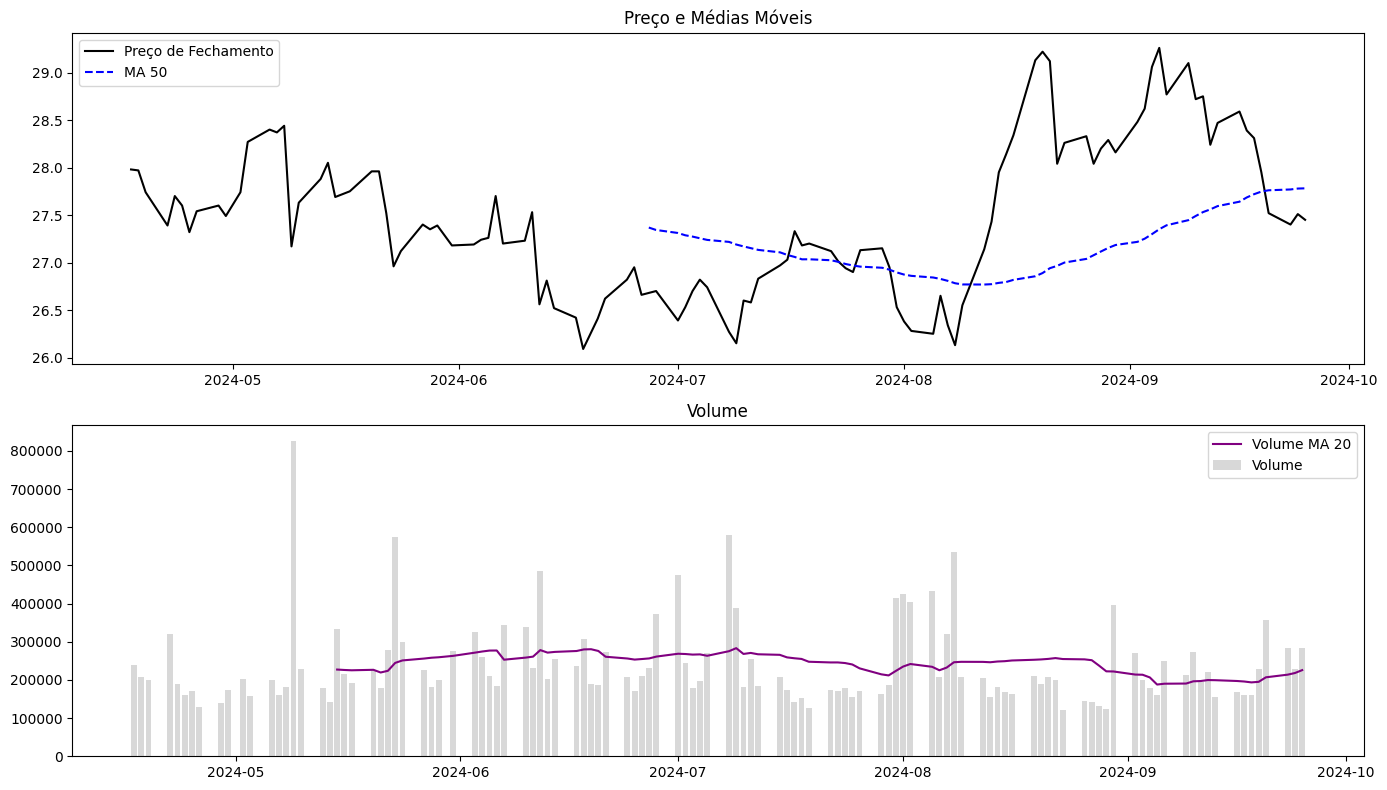

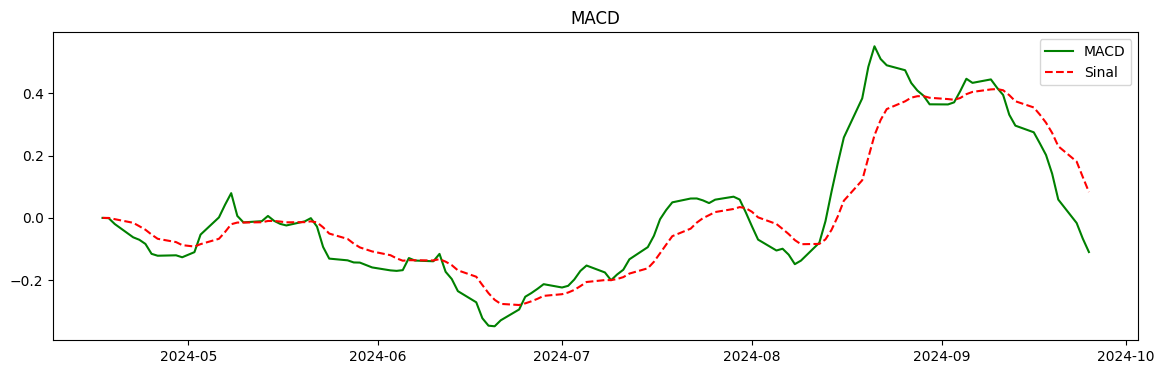

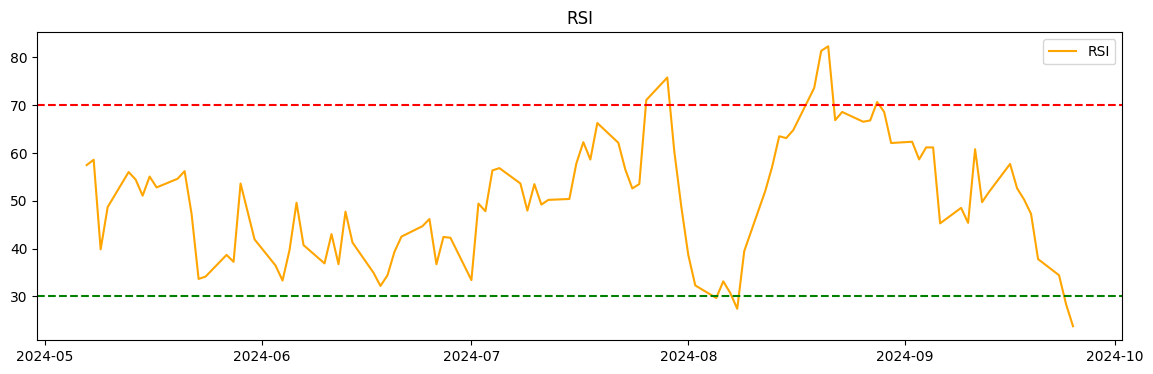

In [8]:
import matplotlib.pyplot as plt

# Plotando o preço de fechamento, médias móveis e volume
plt.figure(figsize=(14, 8))

# Preço de fechamento e médias móveis
plt.subplot(2, 1, 1)
plt.plot(df['time'], df['close'], label='Preço de Fechamento', color='black')
plt.plot(df['time'], df['MA_50'], label='MA 50', color='blue', linestyle='--')
plt.title('Preço e Médias Móveis')
plt.legend()

# Volume e média de volume
plt.subplot(2, 1, 2)
plt.bar(df['time'], df['real_volume'], label='Volume', color='grey', alpha=0.3)
plt.plot(df['time'], df['Volume_MA_20'], label='Volume MA 20', color='purple')
plt.title('Volume')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico do MACD
plt.figure(figsize=(14, 4))
plt.plot(df['time'], df['MACD'], label='MACD', color='green')
plt.plot(df['time'], df['Signal'], label='Sinal', color='red', linestyle='--')
plt.title('MACD')
plt.legend()
plt.show()

# Gráfico do RSI
plt.figure(figsize=(14, 4))
plt.plot(df['time'], df['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('RSI')
plt.legend()
plt.show()

Model is not converging.  Current: 1258.3172302924013 is not greater than 2090.9684960830673. Delta is -832.651265790666
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_25444\4037776126.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = hidden_states


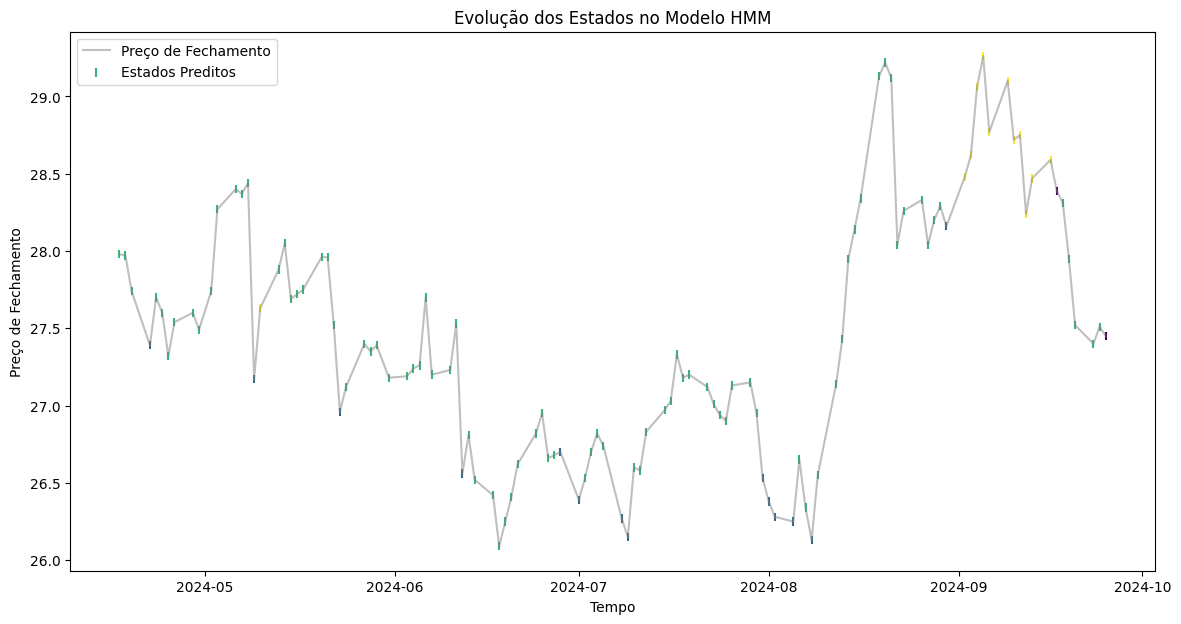

Estado 0:
  Média dos preços de fechamento no estado 0: 27.92
  Quantidade de pontos no estado 0: 2

Estado 1:
  Média dos preços de fechamento no estado 1: 26.67
  Quantidade de pontos no estado 1: 14

Estado 2:
  Média dos preços de fechamento no estado 2: 27.42
  Quantidade de pontos no estado 2: 86

Estado 3:
  Média dos preços de fechamento no estado 3: 28.64
  Quantidade de pontos no estado 3: 12



In [9]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Pré-processamento dos dados
# Vamos utilizar apenas as colunas relevantes para o modelo, exceto a coluna 'time'
df = df[['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume', 'EMA_12', 'EMA_26', 'MACD', 'Signal']]

# Normalizando os dados, exceto a coluna 'time'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['time']))  # Normaliza os dados sem a coluna 'time'

# 2. Definir as variáveis observáveis (features)
X = df_scaled  # Variáveis de entrada (após normalização)

# 3. Ajustar o modelo HMM
model = GaussianHMM(n_components=4, covariance_type='full', n_iter=1000, tol=1e-4, random_state=42)

# Ajustando o modelo aos dados
model.fit(X)

# Forçar a normalização da matriz de transição após o ajuste do modelo
model.transmat_ = np.ones_like(model.transmat_) / model.transmat_.shape[1]

# 4. Prever os estados (soft prediction) para cada ponto de tempo
hidden_states = model.predict(X)

# 5. Adicionar os estados ao DataFrame original (incluindo a coluna 'time')
df['state'] = hidden_states

# 6. Gráfico de Evolução dos Estados ao longo do tempo
plt.figure(figsize=(14,7))
plt.plot(df['time'], df['close'], label='Preço de Fechamento', color='gray', alpha=0.5)
plt.scatter(df['time'], df['close'], c=df['state'], cmap='viridis', label='Estados Preditos', marker='|')
plt.title('Evolução dos Estados no Modelo HMM')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

# Exibindo a distribuição de estados no modelo
for i in range(4):
    print(f"Estado {i}:")
    print(f"  Média dos preços de fechamento no estado {i}: {df[df['state'] == i]['close'].mean():.2f}")
    print(f"  Quantidade de pontos no estado {i}: {df[df['state'] == i].shape[0]}")
    print()


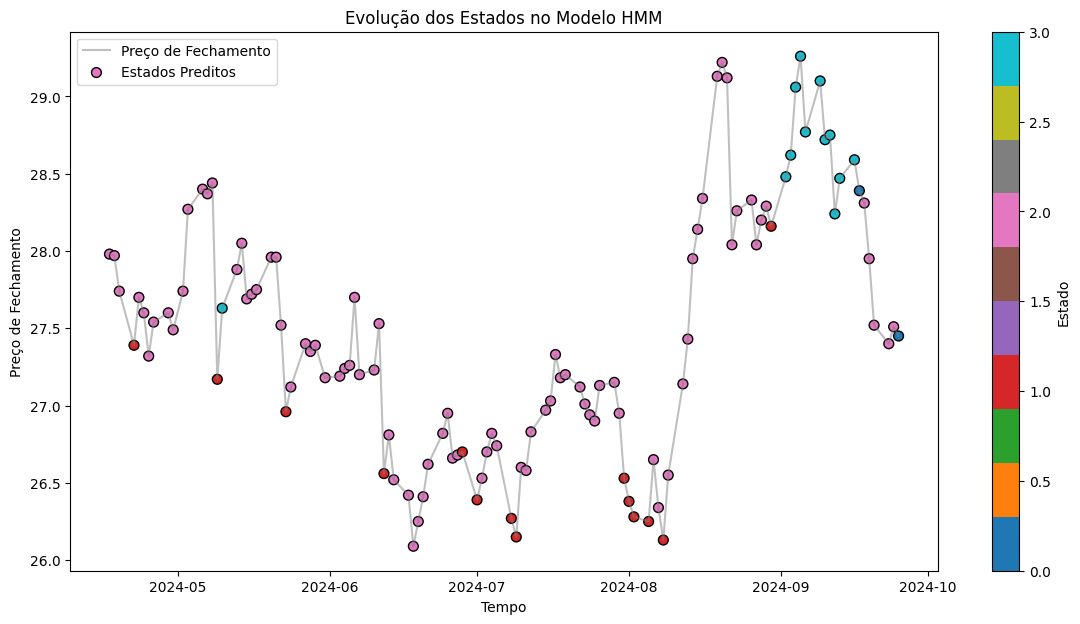

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Definindo um gráfico com mais diferenciação
plt.figure(figsize=(14, 7))

# Plotando o preço de fechamento
plt.plot(df['time'], df['close'], label='Preço de Fechamento', color='gray', alpha=0.5)

# Usando um scatter com marcadores mais visíveis e uma colormap diferenciada
scatter = plt.scatter(df['time'], df['close'], c=df['state'], cmap='tab10', label='Estados Preditos', s=50, marker='o', edgecolor='black')

# Adicionando título e rótulos aos eixos
plt.title('Evolução dos Estados no Modelo HMM')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')

# Adicionando uma barra de cores para os estados
plt.colorbar(scatter, label='Estado')

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.show()
